In [40]:
%pip install seaborn

     |████████████████████████████████| 285 kB 3.6 MB/s 
     |████████████████████████████████| 11.6 MB 8.1 MB/s 
     |████████████████████████████████| 1.1 MB 76.6 MB/s 
     |████████████████████████████████| 14.5 MB 73.4 MB/s 
     |████████████████████████████████| 9.9 MB 63.9 MB/s 
     |████████████████████████████████| 2.2 MB 64.0 MB/s 
     |████████████████████████████████| 67 kB 8.1 MB/s 
     |████████████████████████████████| 227 kB 99.7 MB/s 
     |████████████████████████████████| 510 kB 68.9 MB/s 
     |████████████████████████████████| 25.9 MB 62.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mmdet 2.3.0rc0+c6b5ca2 requires Pillow<=6.2.2, but you have pillow 8.0.1 which is incompatible.
ml-kernel 0.0.1 requires setuptools<=50.3.2, but you have setuptools 51.1.0 which is incompatible.
You should consider upgrading via the '/usr/bin/pyt

In [41]:
%pip install ipympl

     |████████████████████████████████| 2.0 MB 3.1 MB/s 
     |████████████████████████████████| 116 kB 8.8 MB/s 
     |████████████████████████████████| 780 kB 8.2 MB/s 
     |████████████████████████████████| 121 kB 8.6 MB/s 
     |████████████████████████████████| 1.4 MB 8.4 MB/s 
     |████████████████████████████████| 108 kB 9.4 MB/s 
     |████████████████████████████████| 82 kB 1.5 MB/s 
     |████████████████████████████████| 243 kB 8.6 MB/s 
  Using cached matplotlib-3.3.3-cp37-cp37m-manylinux1_x86_64.whl (11.6 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl (1.1 MB)
     |████████████████████████████████| 172 kB 9.7 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
  Using cached numpy-1.19.4-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
     |████████████████████████████████| 93 kB 2.3 MB/s 
     |████████████████████████████████

In [42]:
%matplotlib widget

In [43]:
import csv
import json
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import warnings
import pickle
import os
import seaborn as sns

In [113]:
from catboost import CatBoostRegressor, monoforest, Pool
from catboost.utils import create_cd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, lasso_path, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
from scipy import stats

In [45]:
RANDOM_STATE = 239

In [77]:
warnings.filterwarnings('ignore')

In [47]:
def save_via_pickle(obj, filepath):
    with open(filepath, 'wb') as output_file:
        pickle.dump(obj, output_file)

In [48]:
def load_from_pickle(filepath):
    with open(filepath, 'rb') as input_file:
        return pickle.load(input_file)

In [49]:
PICKLE_DUMPS_PATH = os.path.join('resources', 'pickle_dumps')

In [50]:
def get_pickle_dump_path(dump_name):
    return os.path.join(PICKLE_DUMPS_PATH, f'{dump_name}.pkl')

In [51]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Utils

In [52]:
def print_scores(reg, X_train, X_val, X_test, y_train, y_val, y_test):
    for X_, y_, label  in [(X_train, y_train, 'Train'), (X_val, y_val, 'Val'), (X_test, y_test, 'Test')]:
        print(f'{label} scores:')
        print(f'R2: {reg.score(X_, y_)}')
        print(f'RMSE: {rmse(y_, reg.predict(X_))}')

In [53]:
def build_plot(x, ys, label_x='', label_y='', title=''):
    plt.clf()
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    for y_label, y in ys.items():
        plt.plot(x, y, label=y_label)
    plt.legend()
    plt.show()

In [74]:
def transform_X_catboost(X, monomials):
    X_out = np.ones((X.shape[0], len(monomials)), dtype=np.bool)
    for i, x in enumerate(X):
        for j, monomial in enumerate(monomials):
            for split in monomial.splits:
                X_out[i, j] = X_out[i, j] and np.less_equal(split.border, x[split.feature_idx])
    return X_out

In [55]:
def train_lasso(n_iterations, lambda_arg, X, y):
    return Lasso(max_iter=n_iterations, alpha=lambda_arg).fit(X, y)

def select_lasso_iter(X_train, X_val, y_train, y_val, lambda_arg, max_iter=2000, iter_step=50):
    best_score = None
    best_iter = None
    
    for cur_iter in range(1, max_iter + 1, iter_step):
        lasso = train_lasso(cur_iter, lambda_arg, X_train, y_train)
        cur_score = mean_squared_error(y_val, lasso.predict(X_val), squared=False)
        if best_score is None or cur_score < best_score:
            best_score = cur_score
            best_iter = cur_iter
    
    return best_score, best_iter

def select_lasso_lambda(X_train, X_val, y_train, y_val, lambda_max=1000, lambda_min=1e-4, decay=0.9,
                        max_iter=2000, iter_step=50):
    cur_lambda = lambda_max
    best_score = None
    best_lambda = None
    best_iter = None
    iter_number = 0
    while np.less(lambda_min, cur_lambda):
        cur_score, cur_iter = select_lasso_iter(X_train, X_val, y_train, y_val, cur_lambda,
                                                max_iter, iter_step)
        if best_score is None or cur_score < best_score:
            best_score = cur_score
            best_iter = cur_iter
            best_lambda = cur_lambda
            print(f'New best score: lambda={cur_lambda}, n_iter={cur_iter}, rmse={cur_score}')
        cur_lambda *= decay
        iter_number += 1
        if iter_number % 10 == 0:
            print(f'Iter {iter_number}(lambda={cur_lambda}), best: lambda={best_lambda}, n_iter={best_iter}, rmse={best_score}')
    
    return best_lambda, best_iter, best_score

In [124]:
def bootstrap_scores(catboost_params, lasso_params, 
                     X_train, X_train_mon, 
                     X_val, X_val_mon,
                     X_test, X_test_mon,
                     y_train, y_val, y_test, 
                     n_samples=500,
                     use_r2=False):
    n = X_train.shape[0]
    
    all_ids = []
    diffs = []
    val_diffs = []
    for _ in tqdm(range(n_samples)):
        ids = np.random.choice(np.arange(n), n, replace=True)
        lasso = Lasso(**lasso_params).fit(X_train_mon[ids], y_train[ids])
        reg = CatBoostRegressor(**catboost_params)
        reg.fit(X_train[ids], y_train[ids], eval_set=(X_val, y_val), verbose=False, plot=False)
        if use_r2:
            diffs.append(reg.score(X_test, y_test) - lasso.score(X_test_mon, y_test))
            val_diffs.append(reg.score(X_val, y_val) - lasso.score(X_val_mon, y_val))
        else:
            diffs.append(rmse(y_test, reg.predict(X_test)) - rmse(y_test, lasso.predict(X_test_mon)))
            val_diffs.append(rmse(y_val, reg.predict(X_val)) - rmse(y_val, lasso.predict(X_val_mon)))
        all_ids.append(ids)
    
    sns.distplot(diffs, hist=True, kde=True, 
                 bins=25, color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4},
                 axlabel='rmse')
    return diffs, val_diffs, all_ids

# Catboot models experiments

In [56]:
_, X_train, X_val, X_test, y_train, y_val, y_test = load_from_pickle(get_pickle_dump_path('diabetes_catboost_cbr'))

In [63]:
catboost_argument_grid = {
    'learning_rate': np.hstack([np.arange(0.001, 0.01, 0.001), 
                                np.arange(0.01, 0.1, 0.01), 
                                np.arange(0.1, 0.2, 0.02)]),
    'depth':range(1, 7),
}

In [70]:
regs = {}

## Base tree

In [64]:
base_catboost_reg = CatBoostRegressor(boosting_type='Plain', bootstrap_type='No',
                                      score_function='L2', leaf_estimation_method=None, verbose=False)

In [65]:
%matplotlib inline
grid_search_results = base_catboost_reg.grid_search(catboost_argument_grid, X_train, y_train, 
                                                    cv=5, verbose=0, plot=True)


bestTest = 69.22216061
bestIteration = 999


bestTest = 52.74022409
bestIteration = 999


bestTest = 50.78204768
bestIteration = 998


bestTest = 50.32898696
bestIteration = 996


bestTest = 50.20139881
bestIteration = 990


bestTest = 50.09818774
bestIteration = 987


bestTest = 50.0599708
bestIteration = 997


bestTest = 50.01016881
bestIteration = 998


bestTest = 49.9305471
bestIteration = 997


bestTest = 49.90404379
bestIteration = 999


bestTest = 49.57535119
bestIteration = 939


bestTest = 49.62142362
bestIteration = 742


bestTest = 49.62583361
bestIteration = 605


bestTest = 49.55419972
bestIteration = 458


bestTest = 49.50260086
bestIteration = 377


bestTest = 49.48699617
bestIteration = 333


bestTest = 49.52492996
bestIteration = 302


bestTest = 49.58862494
bestIteration = 257


bestTest = 49.59488375
bestIteration = 258


bestTest = 49.4597677
bestIteration = 145


bestTest = 49.43601713
bestIteration = 149


bestTest = 49.65257597
bestIteration = 160


bestTest = 4

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [68]:
base_catboost_reg = CatBoostRegressor(boosting_type='Plain', bootstrap_type='No',
                                      score_function='L2', leaf_estimation_method=None, verbose=False,
                                      depth=grid_search_results['params']['depth'], learning_rate=grid_search_results['params']['learning_rate'])

In [69]:
base_catboost_reg.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False, plot=True)
print_results(base_catboost_reg, X_train, X_val, X_test, y_train, y_val, y_test)

Train scores:
R2: 0.7853757539212033
RMSE: 35.25995981458112
Val scores:
R2: 0.49807602726038125
RMSE: 61.06133203264467
Test scores:
R2: 0.4318855827216389
RMSE: 52.700996673982054


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [75]:
split_types = set()

feature_ind = 10000
for monomial in monoforest.to_polynom(base_catboost_reg):
    for split in monomial.splits:
        split_types.add(split.split_type)

print(split_types)

regs['base'] = {'reg': base_catboost_reg}
regs['base']['monomials'] = monoforest.to_polynom(base_catboost_reg)
regs['base']['X_train'] = transform_X_catboost(X_train, regs['base']['monomials'])
regs['base']['X_val'] = transform_X_catboost(X_val, regs['base']['monomials'])
regs['base']['X_test'] = transform_X_catboost(X_test, regs['base']['monomials'])
regs['base']['params'] = {
    'boosting_type': 'Plain',
    'bootstrap_type': 'No',
    'score_function': 'L2',
    'leaf_estimation_method': None,
    'depth': grid_search_results['params']['depth'], 
    'learning_rate': grid_search_results['params']['learning_rate']
}

{'TakeGreater'}


In [78]:
select_lasso_lambda(regs['base']['X_train'], regs['base']['X_val'], y_train, y_val, decay=0.75,
                    iter_step=10, lambda_min=1e-3)

New best score: lambda=1000, n_iter=1, rmse=87.21966107613414
Iter 10(lambda=56.313514709472656), best: lambda=1000, n_iter=1, rmse=87.21966107613414
New best score: lambda=17.817948013544083, n_iter=1, rmse=81.84061513453318
New best score: lambda=13.363461010158062, n_iter=1, rmse=75.78121555815959
New best score: lambda=10.022595757618546, n_iter=11, rmse=71.32897338536935
New best score: lambda=7.51694681821391, n_iter=11, rmse=68.08926060231171
New best score: lambda=5.637710113660432, n_iter=11, rmse=65.60200265891736
New best score: lambda=4.228282585245324, n_iter=11, rmse=63.54562422491171
Iter 20(lambda=3.1712119389339932), best: lambda=4.228282585245324, n_iter=11, rmse=63.54562422491171
New best score: lambda=3.1712119389339932, n_iter=11, rmse=62.23953531224978
New best score: lambda=2.378408954200495, n_iter=11, rmse=60.31290518356217
New best score: lambda=1.7838067156503712, n_iter=11, rmse=60.0836902947892
Iter 30(lambda=0.17858209017001472), best: lambda=1.78380671565

KeyboardInterrupt: 

In [81]:
select_lasso_lambda(regs['base']['X_train'], regs['base']['X_val'], y_train, y_val, decay=0.95,
                    iter_step=5, lambda_max=2.378408954200495, lambda_min=1e-1)

New best score: lambda=2.378408954200495, n_iter=11, rmse=60.31290518356217
New best score: lambda=2.25948850649047, n_iter=11, rmse=60.14310791256197
New best score: lambda=2.1465140811659467, n_iter=11, rmse=60.09921284840451
New best score: lambda=1.7483491348226705, n_iter=11, rmse=60.02850541690545
New best score: lambda=1.6609316780815369, n_iter=11, rmse=59.86198922326646
New best score: lambda=1.57788509417746, n_iter=16, rmse=59.790385661473174
New best score: lambda=1.498990839468587, n_iter=16, rmse=59.67244702038057
Iter 10(lambda=1.4240412974951575), best: lambda=1.498990839468587, n_iter=16, rmse=59.67244702038057
New best score: lambda=1.4240412974951575, n_iter=16, rmse=59.65015439172478
Iter 20(lambda=0.8526261278113), best: lambda=1.4240412974951575, n_iter=16, rmse=59.65015439172478


KeyboardInterrupt: 

In [82]:
select_lasso_lambda(regs['base']['X_train'], regs['base']['X_val'], y_train, y_val, decay=0.95,
                    iter_step=1, lambda_max=1.4240412974951575, lambda_min=1.4140412974951575)

New best score: lambda=1.4240412974951575, n_iter=16, rmse=59.65015439172478


(1.4240412974951575, 16, 59.65015439172478)

100%|██████████| 250/250 [17:05<00:00,  4.10s/it]


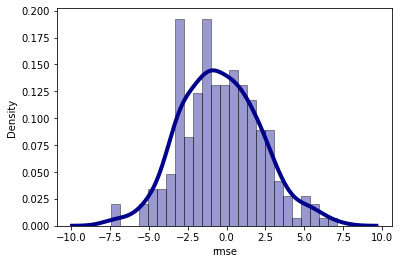

In [90]:
diffs, val_diffs, ids = bootstrap_scores(regs['base']['params'], {'alpha' : 1.4240412974951575, 'max_iter' : 16}, 
                                         X_train, regs['base']['X_train'], 
                                         X_val, regs['base']['X_val'],
                                         X_test, regs['base']['X_test'],
                                         y_train, y_val, y_test, n_samples=250)

In [93]:
regs['base']['ids'] = ids
regs['base']['diffs'] = diffs
regs['base']['val_diffs'] = val_diffs

In [91]:
np.percentile(diffs, 5), np.percentile(diffs, 95), np.percentile(diffs, 50) 

(-4.211434081470083, 3.6790709806840884, -0.4828685620368667)

<AxesSubplot:xlabel='rmse', ylabel='Density'>

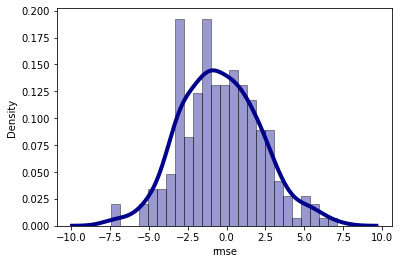

In [100]:
sns.distplot(regs['base']['diffs'], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse')

## Default tree

In [96]:
default_catboost_reg = CatBoostRegressor()
grid_search_results = default_catboost_reg.grid_search(catboost_argument_grid, X_train, y_train, 
                                                       cv=5, verbose=False, plot=True)


bestTest = 73.25659345
bestIteration = 999


bestTest = 55.58677212
bestIteration = 999


bestTest = 52.00169294
bestIteration = 999


bestTest = 50.74419582
bestIteration = 999


bestTest = 50.36706269
bestIteration = 988


bestTest = 49.86957738
bestIteration = 999


bestTest = 49.47582031
bestIteration = 999


bestTest = 49.52749277
bestIteration = 989


bestTest = 49.39608891
bestIteration = 985


bestTest = 49.37210396
bestIteration = 994


bestTest = 48.56130607
bestIteration = 993


bestTest = 48.20444957
bestIteration = 732


bestTest = 48.83773564
bestIteration = 567


bestTest = 48.39858491
bestIteration = 471


bestTest = 47.86160793
bestIteration = 390


bestTest = 48.6097314
bestIteration = 395


bestTest = 48.66842009
bestIteration = 373


bestTest = 49.25566252
bestIteration = 230


bestTest = 48.66397271
bestIteration = 291


bestTest = 47.69262472
bestIteration = 138


bestTest = 47.25351614
bestIteration = 176


bestTest = 48.59511096
bestIteration = 188


bestTest =

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [98]:
grid_search_results['params']

{'depth': 5, 'learning_rate': 0.09}

In [103]:
default_catboost_reg = CatBoostRegressor(verbose=False, depth=grid_search_results['params']['depth'], learning_rate=grid_search_results['params']['learning_rate'])

In [107]:
default_catboost_reg.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False, plot=True, use_best_model=True)
print_results(default_catboost_reg, X_train, X_val, X_test, y_train, y_val, y_test)

Train scores:
R2: 0.7660170864324973
RMSE: 36.815821355396025
Val scores:
R2: 0.4979271214242945
RMSE: 61.070388896764264
Test scores:
R2: 0.4310341555617907
RMSE: 52.74047310618809


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [118]:
split_types = set()

feature_ind = 10000
for monomial in monoforest.to_polynom(default_catboost_reg):
    for split in monomial.splits:
        split_types.add(split.split_type)

print(split_types)

regs['default'] = {'reg': default_catboost_reg}
regs['default']['monomials'] = monoforest.to_polynom(default_catboost_reg)
regs['default']['X_train'] = transform_X_catboost(X_train, regs['default']['monomials'])
regs['default']['X_val'] = transform_X_catboost(X_val, regs['default']['monomials'])
regs['default']['X_test'] = transform_X_catboost(X_test, regs['default']['monomials'])
regs['default']['params'] = {
    'depth' : grid_search_results['params']['depth'], 
    'learning_rate' : grid_search_results['params']['learning_rate'],
    'use_best_model' : True
}

{'TakeGreater'}


In [111]:
select_lasso_lambda(regs['default']['X_train'], regs['default']['X_val'], y_train, y_val, decay=0.75,
                    iter_step=5, lambda_min=1e-1)

New best score: lambda=1000, n_iter=1, rmse=87.21966107613414
Iter 10(lambda=56.313514709472656), best: lambda=1000, n_iter=1, rmse=87.21966107613414
New best score: lambda=17.817948013544083, n_iter=1, rmse=81.63850531793625
New best score: lambda=13.363461010158062, n_iter=1, rmse=73.55779338523567
New best score: lambda=10.022595757618546, n_iter=1, rmse=68.63188069579039
New best score: lambda=7.51694681821391, n_iter=1, rmse=64.43083384794835
New best score: lambda=5.637710113660432, n_iter=1, rmse=62.69012434959494
Iter 20(lambda=3.1712119389339932), best: lambda=5.637710113660432, n_iter=1, rmse=62.69012434959494
New best score: lambda=3.1712119389339932, n_iter=16, rmse=62.5216825296502
New best score: lambda=2.378408954200495, n_iter=16, rmse=61.428580714459336
New best score: lambda=1.7838067156503712, n_iter=16, rmse=60.78312061191869


KeyboardInterrupt: 

In [114]:
lr = LinearRegression().fit(regs['default']['X_train'], y_train)
print_results(lr, regs['default']['X_train'], regs['default']['X_val'], regs['default']['X_test'], y_train, y_val, y_test)

Train scores:
R2: 1.0
RMSE: 2.5965055725736384e-13
Val scores:
R2: 0.11545078396773134
RMSE: 81.06031845908794
Test scores:
R2: 0.025375050890741213
RMSE: 69.02710914813714


In [116]:
select_lasso_lambda(regs['default']['X_train'], regs['default']['X_val'], y_train, y_val, decay=0.8,
                    iter_step=1, lambda_max=1.7838067156503712, lambda_min=1.6)

New best score: lambda=1.7838067156503712, n_iter=18, rmse=60.57114873896826


(1.7838067156503712, 18, 60.57114873896826)

100%|██████████| 250/250 [17:36<00:00,  4.22s/it]


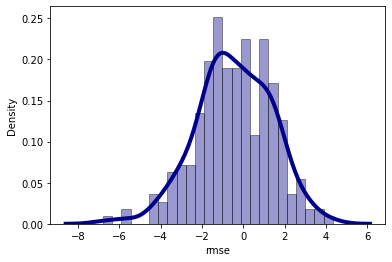

In [119]:
diffs, val_diffs, ids = bootstrap_scores(regs['default']['params'], {'alpha' : 1.7838067156503712, 'max_iter' : 18}, 
                                         X_train, regs['default']['X_train'], 
                                         X_val, regs['default']['X_val'],
                                         X_test, regs['default']['X_test'],
                                         y_train, y_val, y_test, n_samples=250)

In [120]:
regs['default']['ids'] = ids
regs['default']['diffs'] = diffs
regs['default']['val_diffs'] = val_diffs

<AxesSubplot:xlabel='rmse', ylabel='Density'>

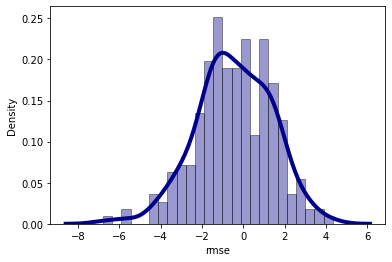

In [122]:
sns.distplot(regs['default']['diffs'], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse')

In [123]:
np.percentile(diffs, 5), np.percentile(diffs, 95), np.percentile(diffs, 50)

(-3.4182557437814802, 2.2585621354224727, -0.4175067252617026)

100%|██████████| 250/250 [17:53<00:00,  4.29s/it]


([-0.011692538084696114,
  0.06423438209733667,
  -0.025709896870118265,
  0.01567391060985368,
  -0.008003468434161998,
  -0.009051891659724642,
  -0.011056898254795222,
  0.022158076736235988,
  0.05735926672168834,
  0.03849133331391841,
  0.0037017735737790436,
  -0.029758150651124526,
  0.016890068670199043,
  0.024039220601853928,
  0.04925699591639704,
  -0.024581272859561465,
  -0.05206973095186285,
  0.05436271202503895,
  -0.03841458076526055,
  -0.024174616605123767,
  0.00911867397008731,
  0.05422734891908876,
  0.02528409986157909,
  0.018160861777680948,
  -0.07181213556525634,
  -0.047672714030231156,
  -0.050246274943758995,
  0.0555715556933295,
  0.06452759448770717,
  -0.0020978951780815658,
  0.02718952892690185,
  0.07033928612152163,
  0.051825659012910696,
  0.009978736717753955,
  -0.006450658384364649,
  0.09738974713997028,
  -0.06677793609808141,
  0.005864696896507371,
  -0.00784034506092618,
  -0.012857917552181353,
  -0.024455738355900758,
  -0.0163660101

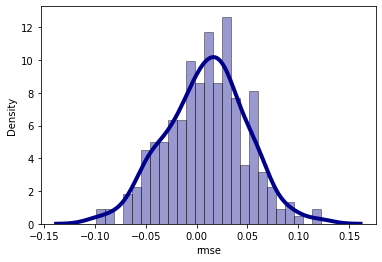

In [126]:
bootstrap_scores(regs['default']['params'], {'alpha' : 1.7838067156503712, 'max_iter' : 18}, 
                 X_train, regs['default']['X_train'], 
                 X_val, regs['default']['X_val'],
                 X_test, regs['default']['X_test'],
                 y_train, y_val, y_test, n_samples=250, use_r2=True)

In [ ]:
base_catboost_reg = CatBoostRegressor(boosting_type='Plain', bootstrap_type='No',
                                      score_function='L2', leaf_estimation_method=None, verbose=False,
                                      depth=grid_search_results['params']['depth'], learning_rate=grid_search_results['params']['learning_rate'])

## Bootstrap

In [145]:
#!L
bootstrap_catboost_reg = CatBoostRegressor(boosting_type='Plain', bootstrap_type='Poisson', iterations=5000,
                                           task_type='GPU',
                                           score_function='L2', leaf_estimation_method=None, verbose=False,
                                           depth=grid_search_results['params']['depth'], learning_rate=grid_search_results['params']['learning_rate'])

In [146]:
#!L
grid_search_results = bootstrap_catboost_reg.grid_search(catboost_argument_grid, X_train, y_train, 
                                                       cv=5, verbose=False, plot=True)

bestTest = 49.50684215
bestIteration = 4995
bestTest = 48.5128719
bestIteration = 4999
bestTest = 48.06528291
bestIteration = 4984
bestTest = 47.9229893
bestIteration = 4984
bestTest = 47.98201686
bestIteration = 4987
bestTest = 48.03657041
bestIteration = 3851
bestTest = 48.07036069
bestIteration = 3851
bestTest = 48.05299389
bestIteration = 2722
bestTest = 47.96901827
bestIteration = 2170
bestTest = 47.949205
bestIteration = 2170
bestTest = 47.73024365
bestIteration = 1449
bestTest = 48.25423577
bestIteration = 615
bestTest = 48.26463822
bestIteration = 615
bestTest = 48.33565385
bestIteration = 443
bestTest = 48.56791107
bestIteration = 372
bestTest = 48.76955253
bestIteration = 404
bestTest = 48.64455097
bestIteration = 210
bestTest = 48.84090728
bestIteration = 272
bestTest = 48.93250577
bestIteration = 272
bestTest = 48.04711702
bestIteration = 117
bestTest = 47.78852577
bestIteration = 114
bestTest = 48.00486156
bestIteration = 118
bestTest = 48.25423577
bestIteration = 84
bestT

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [150]:
#!L
bootstrap_catboost_reg = CatBoostRegressor(boosting_type='Plain', bootstrap_type='Poisson', iterations=10000,
                                           task_type='GPU',
                                           score_function='L2', leaf_estimation_method=None, verbose=False,
                                           depth=grid_search_results['params']['depth'], learning_rate=grid_search_results['params']['learning_rate'])

In [151]:
#!L
bootstrap_catboost_reg.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False, plot=True, use_best_model=True)
print_results(bootstrap_catboost_reg, X_train, X_val, X_test, y_train, y_val, y_test)

Train scores:
R2: 0.8447846857629165
RMSE: 29.98539028632343
Val scores:
R2: 0.428789024763486
RMSE: 65.13967333746007
Test scores:
R2: 0.45889561555643077
RMSE: 51.43295180020162


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [152]:
#!L
split_types = set()

feature_ind = 10000
for monomial in monoforest.to_polynom(bootstrap_catboost_reg):
    for split in monomial.splits:
        split_types.add(split.split_type)

print(split_types)

regs['bootstrap'] = {'reg': bootstrap_catboost_reg}
regs['bootstrap']['monomials'] = monoforest.to_polynom(bootstrap_catboost_reg)
regs['bootstrap']['X_train'] = transform_X_catboost(X_train, regs['bootstrap']['monomials'])
regs['bootstrap']['X_val'] = transform_X_catboost(X_val, regs['bootstrap']['monomials'])
regs['bootstrap']['X_test'] = transform_X_catboost(X_test, regs['bootstrap']['monomials'])
regs['bootstrap']['params'] = {
    'boosting_type': 'Plain',
    'task_type' : 'GPU',
    'bootstrap_type': 'Poisson',
    'score_function': 'L2',
    'leaf_estimation_method': None,
    'depth': grid_search_results['params']['depth'], 
    'learning_rate': grid_search_results['params']['learning_rate']
}

{'TakeGreater'}


In [154]:
#!L
lr = LinearRegression().fit(regs['bootstrap']['X_train'], y_train)
print_results(lr, regs['bootstrap']['X_train'], regs['bootstrap']['X_val'], regs['bootstrap']['X_test'], y_train, y_val, y_test)

Train scores:
R2: 1.0
RMSE: 3.6051619412235137e-13
Val scores:
R2: 0.17809041781989887
RMSE: 78.13746663802955
Test scores:
R2: 0.030338881476281165
RMSE: 68.85110490097203


In [156]:
#!L
warnings.filterwarnings('ignore')

In [157]:
#!L
select_lasso_lambda(regs['default']['X_train'], regs['default']['X_val'], y_train, y_val, decay=0.75,
                    iter_step=5, lambda_min=1e-1, max_iter=5000)

New best score: lambda=1000, n_iter=1, rmse=87.21966107613414
Iter 10(lambda=56.313514709472656), best: lambda=1000, n_iter=1, rmse=87.21966107613414
New best score: lambda=17.817948013544083, n_iter=1, rmse=81.63850531793625
New best score: lambda=13.363461010158062, n_iter=1, rmse=73.55779338523567
New best score: lambda=10.022595757618546, n_iter=1, rmse=68.63188069579039
New best score: lambda=7.51694681821391, n_iter=1, rmse=64.43083384794835
New best score: lambda=5.637710113660432, n_iter=1, rmse=62.690124349594946
Iter 20(lambda=3.1712119389339932), best: lambda=5.637710113660432, n_iter=1, rmse=62.690124349594946
New best score: lambda=3.1712119389339932, n_iter=16, rmse=62.5216825296502
New best score: lambda=2.378408954200495, n_iter=16, rmse=61.428580714459336
New best score: lambda=1.7838067156503712, n_iter=16, rmse=60.78312061191869
Iter 30(lambda=0.17858209017001472), best: lambda=1.7838067156503712, n_iter=16, rmse=60.78312061191869


(1.7838067156503712, 16, 60.78312061191869)